In [1]:
import pandas as pd
pd.options.plotting.backend = "plotly"
import nltk
import numpy as np

# Youtube Data statistics and analysis

In [100]:
data = pd.read_csv("comments.csv")
data.head(10)

,Unnamed: 0.1,Unnamed: 0,videoID,topLevelID,author,published_at,updated_at,like_count,text,commentType
0,0,0,BO8lX3hDU30,0,@GamesVideoisrael,2023-12-05T18:00:09Z,2023-12-05T18:00:09Z,0,nice game,topLevelComment
1,1,1,BO8lX3hDU30,1,@CrowofYharnam,2023-12-05T05:51:29Z,2023-12-05T05:51:29Z,1,GTA 6 trailer 39M views and 5.5M likes in 6 hours,topLevelComment
2,2,2,BO8lX3hDU30,2,@TheMrHotwheels,2023-12-05T04:09:07Z,2023-12-05T04:09:07Z,0,yeah this is still cool as fuk,topLevelComment
3,3,3,BO8lX3hDU30,3,@Adil-ig3gs,2023-12-05T02:51:49Z,2023-12-05T02:51:49Z,2,GTA 6 trailer has gained 25 million views in 3...,topLevelComment
4,4,4,BO8lX3hDU30,4,@BattleBeast5,2023-12-04T15:30:31Z,2023-12-04T15:30:31Z,3,"Most overhyped game ever, just like Chainsaw M...",topLevelComment
5,5,5,BO8lX3hDU30,4,@fredzo15,2023-12-04T20:40:13Z,2023-12-04T20:40:13Z,0,Ya haven’t played it recently have you…,reply
6,6,6,BO8lX3hDU30,5,@Eagerwerewolf,2023-11-30T05:15:00Z,2023-11-30T05:15:00Z,2,This game is absolutely beautiful,topLevelComment
7,7,7,BO8lX3hDU30,6,@vareos9874,2023-11-28T23:15:44Z,2023-11-28T23:15:44Z,1,yknow as misleading as a lot of the early mark...,topLevelComment
8,8,8,BO8lX3hDU30,6,@devondre79,2023-12-03T07:19:00Z,2023-12-03T07:19:00Z,0,Not really,reply
9,9,9,BO8lX3hDU30,6,@vareos9874,2023-12-03T10:51:31Z,2023-12-03T10:51:31Z,0,​@@devondre79name 1 thing in this trailer that...,reply


In [101]:
original_len = len(data)
print(f"Number of scraped comments: {original_len}")

Number of scraped comments: 328875


## Preprocessing and Vectorizing

### removing rows with no text

In [102]:
# remove lines with empty text field
for index, row in data.iterrows():
    if pd.isnull(row["text"]):
        data.drop(index=index, inplace=True)
print(f"removed {original_len - len(data)} entries")

removed 3 entries


### html cleaning, tokenization

In [103]:
import spacy
import re
from bs4 import BeautifulSoup
import html as ihtml

# from https://www.kaggle.com/code/ceshine/remove-html-tags-using-beautifulsoup
def clean_text(text):
    text = BeautifulSoup(ihtml.unescape(text)).get_text(separator=" ").strip()
    text = re.sub(r"http[s]?://\S+", " ", text)
    text = re.sub(r"\s+", " ", text)    
    return text

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner', 'textcat'])
def preprocess(text):
    """Preprocess the given text by tokenising it, removing any stop words, 
    replacing each remaining token with its lemma (base form), and discarding 
    all lemmas that contain non-alphabetical characters.

    Arguments:
      text (str): The text to preprocess.

    Returns:
      The list of remaining lemmas after preprocessing (represented as strings).
    """

    doc = nlp(clean_text(text))
    data = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return data

In [104]:
words = [preprocess(text) for text in data['text']]
text_clean = [clean_text(text) for text in data['text']]

C:\Users\yanni\AppData\Local\Temp\ipykernel_25040\3254064293.py:8: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

C:\Users\yanni\AppData\Local\Temp\ipykernel_25040\3254064293.py:8: MarkupResemblesLocatorWarning:

The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.



In [105]:
data["preprocessed"] = words
data["text"] = text_clean

In [106]:
# pickle data
data.to_pickle("prep_data.pkl")

## YouTube Data

### Comment frequency over time

In [3]:
data = pd.read_pickle("prep_data.pkl")
print(f"loaded number of comments: {len(data)}")

loaded number of comments: 328872


In [4]:
data.index = pd.to_datetime(data["updated_at"],format='%Y-%m-%dT%H:%M:%SZ')
freq_df = data.groupby(pd.Grouper(freq="d"))["updated_at"].count()

In [48]:
import plotly.graph_objects as go
from datetime import datetime

fig1=go.Figure()
# comment frequency
freq_plt = go.Scatter(x = freq_df.index, y = freq_df, mode="lines", name = "number of comments")
# zero values
zeros = freq_df.loc[freq_df == 0]
zero_values_plt = go.Scatter(x=zeros.index, y=zeros, mode="markers", name = "zero comments")
# video release dates
rdates = ["2020-11-19","2013-01-10","2018-06-10","2018-08-27","2020-10-01",
          "2019-06-09","2019-06-09","2020-12-09","2013-01-10","2020-12-18"]
rdates_df = freq_df.loc[freq_df.index.isin(rdates)]
rdates_plt = go.Scatter(x=rdates_df.index, y=rdates_df, mode="markers", name = "video release")

fig1.add_trace(freq_plt)
fig1.add_trace(zero_values_plt)
fig1.add_trace(rdates_plt)
# release date
fig1.add_vline(x = datetime.strptime("2020-12-10", "%Y-%m-%d").timestamp() * 1000,line_dash="dot",line_color="black",opacity=0.8,
              annotation_text="game release",annotation_position="top")
fig1.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))
fig1.update_yaxes(title="number of comments")
fig1.update_xaxes(title="date")
fig1.show()

In [195]:
import numpy as np
np.log(freq_df).plot()

fig2=go.Figure()
# comment frequency
freq_plt = go.Scatter(x = freq_df.index, y = np.log(freq_df), mode="lines", name = "number of comments")
zero_values_plt = go.Scatter(x=zeros.index, y=[0]*len(zeros), mode="markers", name = "zero comments")
rdates_plt = go.Scatter(x=rdates_df.index, y=np.log(rdates_df), mode="markers", name = "video release")

fig2.add_trace(freq_plt)
fig2.add_trace(zero_values_plt)
fig2.add_trace(rdates_plt)
# release date
fig2.add_vline(x = datetime.strptime("2020-12-10", "%Y-%m-%d").timestamp() * 1000,line_dash="dot",line_color="black",opacity=0.8,
              annotation_text="game release",annotation_position="bottom")
fig2.show()

c:\Users\yanni\anaconda3\envs\youtube_comments\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning:

divide by zero encountered in log



In [56]:
# monthly comment stats
print("including before game release")
monthly_df = data.groupby(pd.Grouper(freq="M"))["updated_at"].count()
print(f"The month with the highest amount of comments was {monthly_df.idxmax().date()} with {monthly_df[monthly_df.idxmax()]} comments.")
print(f"The month with the lowest amount of comments was {monthly_df.idxmin().date()} with {monthly_df[monthly_df.idxmin()]} comments.")
print(f"The average number of comments per month is {monthly_df.mean():.3f}.")


print("after game release")
monthly_df = monthly_df[monthly_df.index > "2020-11-30"]
print(f"The month with the highest amount of comments was {monthly_df.idxmax().date()} with {monthly_df[monthly_df.idxmax()]} comments.")
print(f"The month with the lowest amount of comments was {monthly_df.idxmin().date()} with {monthly_df[monthly_df.idxmin()]} comments.")
print(f"The average number of comments per month is {monthly_df.mean():.3f}.")

including before game release
The month with the highest amount of comments was 2020-12-31 with 60731 comments.
The month with the lowest amount of comments was 2015-09-30 with 48 comments.
The average number of comments per month is 2491.455.
after game release
The month with the highest amount of comments was 2020-12-31 with 60731 comments.
The month with the lowest amount of comments was 2023-12-31 with 201 comments.
The average number of comments per month is 2518.703.


In [57]:
# weekly comment stats
print("including before game release")
weekly_df = data.groupby(pd.Grouper(freq="w"))["updated_at"].count()
print(f"The week with the highest amount of comments was {weekly_df.idxmax().date()} with {weekly_df[weekly_df.idxmax()]} comments.")
print(f"The week with the lowest amount of comments was {weekly_df.idxmin().date()} with {weekly_df[weekly_df.idxmin()]} comments.")
print(f"The average number of comments per week is {weekly_df.mean():.3f}.")


print("after game release")
weekly_df = weekly_df[weekly_df.index > "2020-11-30"]
print(f"The week with the highest amount of comments was {weekly_df.idxmax().date()} with {weekly_df[weekly_df.idxmax()]} comments.")
print(f"The week with the lowest amount of comments was {weekly_df.idxmin().date()} with {weekly_df[weekly_df.idxmin()]} comments.")
print(f"The average number of comments per week is {weekly_df.mean():.3f}.")

including before game release
The week with the highest amount of comments was 2018-09-02 with 43326 comments.
The week with the lowest amount of comments was 2014-12-21 with 5 comments.
The average number of comments per week is 576.968.
after game release
The week with the highest amount of comments was 2020-12-13 with 35324 comments.
The week with the lowest amount of comments was 2023-05-28 with 40 comments.
The average number of comments per week is 594.443.


In [32]:
# comments per video
video_df = data.groupby("videoID")["videoID"].count()
video_df

videoID
8X2kIfS6fb8    35920
BO8lX3hDU30    32175
DvVjkqB3LH0    16209
G51GkSmQAmQ    25256
LembwKDo1Dk    18676
P99qJGrPNLs    66155
U8qJc6znzZc     7383
qIcTM8WXFjk    32371
uRYsVL2RNNY     3444
vjF9GgrY9c0    91283
Name: videoID, dtype: int64

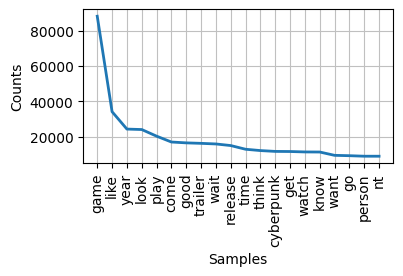

<Axes: xlabel='Samples', ylabel='Counts'>

In [69]:
from itertools import chain
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 2))
# flatten list for freqdist
words = data["preprocessed"]
fd = nltk.FreqDist(list(chain.from_iterable(words)))
fd.plot(20)

## Model evaluation on labled data

In [2]:
# loading data
reviews = pd.read_pickle("steam_reviews.pkl")
reviews['voted_up'].replace({True: 1, False: -1}, inplace=True)
reviews.head(2)

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china,steam_china_location,timestamp_dev_responded,developer_response
2024-01-07 17:04:14,155462372,"{'steamid': '76561198169337147', 'num_games_ow...",brazilian,Tendo terminado esse jogo em seu lançamento e ...,1704618897,1704643454,1,1,0,0.52173912525177002,0,False,False,False,True,,NaN,NaN
2024-01-07 17:03:38,155487141,"{'steamid': '76561198031762568', 'num_games_ow...",polish,Wspamiała gra ! <3,1704643418,1704643418,1,0,0,0,0,True,False,False,True,,NaN,NaN


In [3]:
# bertweet pipeline
from transformers import pipeline
import torch
device = 0 if torch.cuda.is_available() else -1
# check if GPU has been found (device: 0)
print(f"device: {device}")
# set up pipeline
pipe = pipeline("text-classification", model="finiteautomata/bertweet-base-sentiment-analysis", device=0, batch_size=5)
# test if it works
pipe.predict("this is a test")

c:\Users\yanni\anaconda3\envs\youtube_comments_transformers\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device: 0


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


[{'label': 'NEU', 'score': 0.9221327900886536}]

In [4]:
# constructing test set
english_reviews = reviews[reviews["language"] == "english"]
test_set = english_reviews.sample(n = 50000, replace = False, random_state = 12345)
long_examples = []
for index, row in test_set.iterrows():
    txt = row["review"]
    if len(pipe.tokenizer.tokenize(txt)) > 128:
        long_examples.append(index)
print(f"{len(long_examples)} long reviews will be dropped.")
test_set.drop(index=long_examples, inplace = True)
print(f"test set now contains {len(test_set)} samples.")
test_set.head(2)

7232 long reviews will be dropped.
test set now contains 42722 samples.


,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china,steam_china_location,timestamp_dev_responded,developer_response
2022-08-13 10:45:00,120545674,"{'steamid': '76561199367097110', 'num_games_ow...",english,Absolutely one of the most visually stunning o...,1660380300,1660380300,1,0,0,0,0,True,False,False,False,,NaN,NaN
2022-09-19 21:29:50,122496929,"{'steamid': '76561198097730799', 'num_games_ow...",english,I hate that some people have weird issues with...,1663615790,1663615790,1,4,0,0.525521218776702881,0,True,False,False,True,,NaN,NaN


In [5]:
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()
compound_score_lst = []
for index, row in test_set.iterrows():
    txt = row["review"]
    compound_score_lst.append(sia.polarity_scores(txt)["compound"])
test_set["nltk_compound_score"] = compound_score_lst

new_score = []
for index, row in test_set.iterrows():
    if row["nltk_compound_score"] > 0:
        new_score.append(1)
    elif row["nltk_compound_score"] < 0:
        new_score.append(-1)
    else:
        new_score.append(0)
test_set["new_nltk_score"] = new_score
test_set.head(2)


,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china,steam_china_location,timestamp_dev_responded,developer_response,nltk_compound_score,new_nltk_score
2022-08-13 10:45:00,120545674,"{'steamid': '76561199367097110', 'num_games_ow...",english,Absolutely one of the most visually stunning o...,1660380300,1660380300,1,0,0,0,0,True,False,False,False,,NaN,NaN,0.7832,1
2022-09-19 21:29:50,122496929,"{'steamid': '76561198097730799', 'num_games_ow...",english,I hate that some people have weird issues with...,1663615790,1663615790,1,4,0,0.525521218776702881,0,True,False,False,True,,NaN,NaN,0.6679,1


In [6]:
from datasets import Dataset
# convert into huggingface dataset
dataset = Dataset.from_pandas(test_set[["review", "voted_up"]])
# to GPU
dataset.set_format(type="torch", device="cuda")
# run pipeline on test set
results = pipe(dataset["review"], padding=True,truncation=True,max_length=128)

In [7]:
bertweet_labels = []
for result in results:
    bertweet_labels.append(result["label"])
test_set["bertweet_labels"] = bertweet_labels
test_set['bertweet_labels'].replace({'POS': 1, 'NEU': 0, 'NEG': -1}, inplace=True)
test_set.head(2)

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,...,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china,steam_china_location,timestamp_dev_responded,developer_response,nltk_compound_score,new_nltk_score,bertweet_labels
2022-08-13 10:45:00,120545674,"{'steamid': '76561199367097110', 'num_games_ow...",english,Absolutely one of the most visually stunning o...,1660380300,1660380300,1,0,0,0,...,True,False,False,False,,NaN,NaN,0.7832,1,1
2022-09-19 21:29:50,122496929,"{'steamid': '76561198097730799', 'num_games_ow...",english,I hate that some people have weird issues with...,1663615790,1663615790,1,4,0,0.525521218776702881,...,True,False,False,True,,NaN,NaN,0.6679,1,1


In [1]:
# pickle data
test_set.to_pickle("test_set.pkl")

NameError: name 'test_set' is not defined

In [1]:
import pandas as pd

In [2]:
test_set = pd.read_pickle("test_set.pkl")

In [19]:
from sklearn import metrics
metrics_lst = metrics.precision_recall_fscore_support(y_true = test_set["voted_up"].tolist(), y_pred = test_set["new_nltk_score"].tolist(), beta = 1)
precision = metrics_lst[0]
recall = metrics_lst[1]
fscore = metrics_lst[2]
support = metrics_lst[3]
print("nltk model")
print(f"support: {support}")
print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"f1score: {fscore}")

nltk model
support: [ 5827     0 36895]
precision: [0.47328513 0.         0.93203093]
recall: [0.46061438 0.         0.74481637]
f1score: [0.4668638 0.        0.8279727]


c:\Users\yanni\anaconda3\envs\scikit_pandas2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
metrics_lst = metrics.precision_recall_fscore_support(y_true = test_set["voted_up"].tolist(), y_pred = test_set["bertweet_labels"].tolist(), beta = 1)
precision = metrics_lst[0]
recall = metrics_lst[1]
fscore = metrics_lst[2]
support = metrics_lst[3]
print("bertweet model")
print(f"support: {support}")
print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"f1score: {fscore}")

bertweet model
support: [ 5827     0 36895]
precision: [0.61959929 0.         0.98926249]
recall: [0.78016132 0.         0.7216696 ]
f1score: [0.69067153 0.         0.83454004]


c:\Users\yanni\anaconda3\envs\scikit_pandas2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Sentiment Analysis

In [6]:
data = pd.read_pickle("prep_data.pkl")

### using nltk

In [24]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
compound_score_lst = []
for index, row in data.iterrows():
    txt = row["text"]
    compound_score_lst.append(sia.polarity_scores(txt)["compound"])
data["nltk_compound_score"] = compound_score_lst

### using bertweet

In [2]:
from transformers import pipeline
import torch
device = 0 if torch.cuda.is_available() else -1
# check if GPU has been found (device: 0)
print(f"device: {device}")
# set up pipeline
pipe = pipeline("text-classification", model="finiteautomata/bertweet-base-sentiment-analysis", device=0, batch_size=5)
# test if it works
pipe.predict("this is a test")

c:\Users\yanni\anaconda3\envs\youtube_comments_transformers\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device: 0


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


[{'label': 'NEU', 'score': 0.9221327900886536}]

In [7]:
from datasets import Dataset
# convert into huggingface dataset
dataset = Dataset.from_pandas(data)
# to GPU
dataset.set_format(type="torch", device="cuda")

In [18]:
# quick check: how many comments are longer than 128 tokens?
long_examples = []
for index, row in data.iterrows():
    txt = row["text"]
    if len(pipe.tokenizer.tokenize(txt)) > 128:
        long_examples.append(txt)

3261


In [31]:
long_num = len(long_examples)
long_percent = long_num / len(data) * 100
long_lengths = [len(comment) for comment in long_examples]
long_min = min(long_lengths)
long_max = max(long_lengths)
long_mean = np.mean(long_lengths)
print(f"There were {long_num} examples longer than 128 tokens after tokenization.")
print(f"That is {long_percent:.3f}% of the data.")
print(f"Their length ranges between {long_min} and {long_max} tokens")
print(f"with an average of {long_mean:.3f} tokens")


There were 3261 examples longer than 128 tokens after tokenization.
That is 0.992% of the data.
Their length ranges between 148 and 10000 tokens
with an average of 897.399 tokens


In [ ]:
# run pipeline on all comments
results = pipe(dataset["text"], padding=True,truncation=True,max_length=128)

In [27]:
bertweet_labels = []
for result in results:
    bertweet_labels.append(result["label"])
data["bertweet_labels"] = bertweet_labels
data['bertweet_labels'].replace({'POS': 1, 'NEU': 0, 'NEG': -1}, inplace=True)
data.head(10)

,Unnamed: 0.1,Unnamed: 0,videoID,topLevelID,author,published_at,updated_at,like_count,text,commentType,update_date,update_time,preprocessed,nltk_compound_score,bertweet_labels
0,0,0,BO8lX3hDU30,0,@GamesVideoisrael,2023-12-05T18:00:09Z,2023-12-05T18:00:09Z,0,nice game,topLevelComment,2023-12-05,18:00:09Z,"[nice, game]",0.4215,POS
1,1,1,BO8lX3hDU30,1,@CrowofYharnam,2023-12-05T05:51:29Z,2023-12-05T05:51:29Z,1,GTA 6 trailer 39M views and 5.5M likes in 6 hours,topLevelComment,2023-12-05,05:51:29Z,"[GTA, trailer, m, view, m, like, hour]",0.4215,POS
2,2,2,BO8lX3hDU30,2,@TheMrHotwheels,2023-12-05T04:09:07Z,2023-12-05T04:09:07Z,0,yeah this is still cool as fuk,topLevelComment,2023-12-05,04:09:07Z,"[yeah, cool, fuk]",0.5423,POS
3,3,3,BO8lX3hDU30,3,@Adil-ig3gs,2023-12-05T02:51:49Z,2023-12-05T02:51:49Z,2,GTA 6 trailer has gained 25 million views in 3...,topLevelComment,2023-12-05,02:51:49Z,"[GTA, trailer, gain, million, view, hour, amaz...",0.7712,POS
4,4,4,BO8lX3hDU30,4,@BattleBeast5,2023-12-04T15:30:31Z,2023-12-04T15:30:31Z,3,"Most overhyped game ever, just like Chainsaw M...",topLevelComment,2023-12-04,15:30:31Z,"[overhyped, game, like, Chainsaw, Man, overhyp...",-0.2500,NEG
5,5,5,BO8lX3hDU30,4,@fredzo15,2023-12-04T20:40:13Z,2023-12-04T20:40:13Z,0,Ya haven’t played it recently have you…,reply,2023-12-04,20:40:13Z,"[Ya, play, recently]",0.3400,NEU
6,6,6,BO8lX3hDU30,5,@Eagerwerewolf,2023-11-30T05:15:00Z,2023-11-30T05:15:00Z,2,This game is absolutely beautiful,topLevelComment,2023-11-30,05:15:00Z,"[game, absolutely, beautiful]",0.6361,POS
7,7,7,BO8lX3hDU30,6,@vareos9874,2023-11-28T23:15:44Z,2023-11-28T23:15:44Z,1,yknow as misleading as a lot of the early mark...,topLevelComment,2023-11-28,23:15:44Z,"[yknow, misleading, lot, early, marketing, dow...",-0.4019,NEG
8,8,8,BO8lX3hDU30,6,@devondre79,2023-12-03T07:19:00Z,2023-12-03T07:19:00Z,0,Not really,reply,2023-12-03,07:19:00Z,[],0.0000,NEU
9,9,9,BO8lX3hDU30,6,@vareos9874,2023-12-03T10:51:31Z,2023-12-03T10:51:31Z,0,​@@devondre79name 1 thing in this trailer that...,reply,2023-12-03,10:51:31Z,"[thing, trailer, nt, game]",0.0000,NEU


In [6]:
# pickle data
data.to_pickle("analyzed_data.pkl")

### comparison over time

In [2]:
data = pd.read_pickle("analyzed_data.pkl")
print(f"loaded number of comments: {len(data)}")
data.head(10)

loaded number of comments: 328872


,Unnamed: 0.1,Unnamed: 0,videoID,topLevelID,author,published_at,updated_at,like_count,text,commentType,update_date,update_time,preprocessed,nltk_compound_score,bertweet_labels
0,0,0,BO8lX3hDU30,0,@GamesVideoisrael,2023-12-05T18:00:09Z,2023-12-05T18:00:09Z,0,nice game,topLevelComment,2023-12-05,18:00:09Z,"[nice, game]",0.4215,1
1,1,1,BO8lX3hDU30,1,@CrowofYharnam,2023-12-05T05:51:29Z,2023-12-05T05:51:29Z,1,GTA 6 trailer 39M views and 5.5M likes in 6 hours,topLevelComment,2023-12-05,05:51:29Z,"[GTA, trailer, m, view, m, like, hour]",0.4215,1
2,2,2,BO8lX3hDU30,2,@TheMrHotwheels,2023-12-05T04:09:07Z,2023-12-05T04:09:07Z,0,yeah this is still cool as fuk,topLevelComment,2023-12-05,04:09:07Z,"[yeah, cool, fuk]",0.5423,1
3,3,3,BO8lX3hDU30,3,@Adil-ig3gs,2023-12-05T02:51:49Z,2023-12-05T02:51:49Z,2,GTA 6 trailer has gained 25 million views in 3...,topLevelComment,2023-12-05,02:51:49Z,"[GTA, trailer, gain, million, view, hour, amaz...",0.7712,1
4,4,4,BO8lX3hDU30,4,@BattleBeast5,2023-12-04T15:30:31Z,2023-12-04T15:30:31Z,3,"Most overhyped game ever, just like Chainsaw M...",topLevelComment,2023-12-04,15:30:31Z,"[overhyped, game, like, Chainsaw, Man, overhyp...",-0.2500,-1
5,5,5,BO8lX3hDU30,4,@fredzo15,2023-12-04T20:40:13Z,2023-12-04T20:40:13Z,0,Ya haven’t played it recently have you…,reply,2023-12-04,20:40:13Z,"[Ya, play, recently]",0.3400,0
6,6,6,BO8lX3hDU30,5,@Eagerwerewolf,2023-11-30T05:15:00Z,2023-11-30T05:15:00Z,2,This game is absolutely beautiful,topLevelComment,2023-11-30,05:15:00Z,"[game, absolutely, beautiful]",0.6361,1
7,7,7,BO8lX3hDU30,6,@vareos9874,2023-11-28T23:15:44Z,2023-11-28T23:15:44Z,1,yknow as misleading as a lot of the early mark...,topLevelComment,2023-11-28,23:15:44Z,"[yknow, misleading, lot, early, marketing, dow...",-0.4019,-1
8,8,8,BO8lX3hDU30,6,@devondre79,2023-12-03T07:19:00Z,2023-12-03T07:19:00Z,0,Not really,reply,2023-12-03,07:19:00Z,[],0.0000,0
9,9,9,BO8lX3hDU30,6,@vareos9874,2023-12-03T10:51:31Z,2023-12-03T10:51:31Z,0,​@@devondre79name 1 thing in this trailer that...,reply,2023-12-03,10:51:31Z,"[thing, trailer, nt, game]",0.0000,0


In [3]:
data.index = pd.to_datetime(data["updated_at"],format='%Y-%m-%dT%H:%M:%SZ')
data.head(2)

,Unnamed: 0.1,Unnamed: 0,videoID,topLevelID,author,published_at,updated_at,like_count,text,commentType,update_date,update_time,preprocessed,nltk_compound_score,bertweet_labels
updated_at,,,,,,,,,,,,,,,
2023-12-05 18:00:09,0,0,BO8lX3hDU30,0,@GamesVideoisrael,2023-12-05T18:00:09Z,2023-12-05T18:00:09Z,0,nice game,topLevelComment,2023-12-05,18:00:09Z,"[nice, game]",0.4215,1
2023-12-05 05:51:29,1,1,BO8lX3hDU30,1,@CrowofYharnam,2023-12-05T05:51:29Z,2023-12-05T05:51:29Z,1,GTA 6 trailer 39M views and 5.5M likes in 6 hours,topLevelComment,2023-12-05,05:51:29Z,"[GTA, trailer, m, view, m, like, hour]",0.4215,1


In [48]:
df1 = data.groupby(pd.Grouper(freq="M"))[["bertweet_labels","nltk_compound_score"]].mean()

In [49]:
import plotly.graph_objects as go
from datetime import datetime

fig3=go.Figure()
# monthly sentiment
monthly_bertweet = go.Scatter(x = df1.index, y = df1["bertweet_labels"], mode="lines", name = "BERTweet")
monthly_vader = go.Scatter(x = df1.index, y = df1["nltk_compound_score"], mode="lines", name = "VADER")

fig3.add_trace(monthly_bertweet)
fig3.add_trace(monthly_vader)
# release date
fig3.add_vline(x = datetime.strptime("2020-12-10", "%Y-%m-%d").timestamp() * 1000,line_dash="dot",line_color="black",opacity=0.8,
              annotation_text="game release",annotation_position="top")
#fig3.update_layout(legend=dict(
#    yanchor="top",
#    y=0.99,
#    xanchor="right",
#    x=0.99
#))
fig3.update_yaxes(title="monthly score")
fig3.update_xaxes(title="date")
fig3.show()

In [6]:
# test: what if nltk compound score is -1, 0, 1
new_score = []
for index, row in data.iterrows():
    if row["nltk_compound_score"] > 0:
        new_score.append(1)
    elif row["nltk_compound_score"] < 0:
        new_score.append(-1)
    else:
        new_score.append(0)
data["new_nltk_score"] = new_score
data.head(10)


,Unnamed: 0.1,Unnamed: 0,videoID,topLevelID,author,published_at,updated_at,like_count,text,commentType,update_date,update_time,preprocessed,nltk_compound_score,bertweet_labels,new_nltk_score
updated_at,,,,,,,,,,,,,,,,
2023-12-05 18:00:09,0,0,BO8lX3hDU30,0,@GamesVideoisrael,2023-12-05T18:00:09Z,2023-12-05T18:00:09Z,0,nice game,topLevelComment,2023-12-05,18:00:09Z,"[nice, game]",0.4215,1,1
2023-12-05 05:51:29,1,1,BO8lX3hDU30,1,@CrowofYharnam,2023-12-05T05:51:29Z,2023-12-05T05:51:29Z,1,GTA 6 trailer 39M views and 5.5M likes in 6 hours,topLevelComment,2023-12-05,05:51:29Z,"[GTA, trailer, m, view, m, like, hour]",0.4215,1,1
2023-12-05 04:09:07,2,2,BO8lX3hDU30,2,@TheMrHotwheels,2023-12-05T04:09:07Z,2023-12-05T04:09:07Z,0,yeah this is still cool as fuk,topLevelComment,2023-12-05,04:09:07Z,"[yeah, cool, fuk]",0.5423,1,1
2023-12-05 02:51:49,3,3,BO8lX3hDU30,3,@Adil-ig3gs,2023-12-05T02:51:49Z,2023-12-05T02:51:49Z,2,GTA 6 trailer has gained 25 million views in 3...,topLevelComment,2023-12-05,02:51:49Z,"[GTA, trailer, gain, million, view, hour, amaz...",0.7712,1,1
2023-12-04 15:30:31,4,4,BO8lX3hDU30,4,@BattleBeast5,2023-12-04T15:30:31Z,2023-12-04T15:30:31Z,3,"Most overhyped game ever, just like Chainsaw M...",topLevelComment,2023-12-04,15:30:31Z,"[overhyped, game, like, Chainsaw, Man, overhyp...",-0.2500,-1,-1
2023-12-04 20:40:13,5,5,BO8lX3hDU30,4,@fredzo15,2023-12-04T20:40:13Z,2023-12-04T20:40:13Z,0,Ya haven’t played it recently have you…,reply,2023-12-04,20:40:13Z,"[Ya, play, recently]",0.3400,0,1
2023-11-30 05:15:00,6,6,BO8lX3hDU30,5,@Eagerwerewolf,2023-11-30T05:15:00Z,2023-11-30T05:15:00Z,2,This game is absolutely beautiful,topLevelComment,2023-11-30,05:15:00Z,"[game, absolutely, beautiful]",0.6361,1,1
2023-11-28 23:15:44,7,7,BO8lX3hDU30,6,@vareos9874,2023-11-28T23:15:44Z,2023-11-28T23:15:44Z,1,yknow as misleading as a lot of the early mark...,topLevelComment,2023-11-28,23:15:44Z,"[yknow, misleading, lot, early, marketing, dow...",-0.4019,-1,-1
2023-12-03 07:19:00,8,8,BO8lX3hDU30,6,@devondre79,2023-12-03T07:19:00Z,2023-12-03T07:19:00Z,0,Not really,reply,2023-12-03,07:19:00Z,[],0.0000,0,0


In [7]:
df1 = data.groupby(pd.Grouper(freq="M"))[["bertweet_labels","new_nltk_score","nltk_compound_score"]].mean()
df1.plot()

## Comparison to Steam reviews

In [30]:
reviews = pd.read_pickle("steam_reviews.pkl")
reviews['voted_up'].replace({True: 1, False: -1}, inplace=True)
reviews.head(2)

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china,steam_china_location,timestamp_dev_responded,developer_response
2024-01-07 17:04:14,155462372,"{'steamid': '76561198169337147', 'num_games_ow...",brazilian,Tendo terminado esse jogo em seu lançamento e ...,1704618897,1704643454,1,1,0,0.52173912525177002,0,False,False,False,True,,NaN,NaN
2024-01-07 17:03:38,155487141,"{'steamid': '76561198031762568', 'num_games_ow...",polish,Wspamiała gra ! <3,1704643418,1704643418,1,0,0,0,0,True,False,False,True,,NaN,NaN


In [9]:
reviews.tail(2)

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china,steam_china_location,timestamp_dev_responded,developer_response
2020-12-10 01:11:10,81918912,"{'steamid': '76561198044596404', 'num_games_ow...",english,Obligatory It’s breathtaking!\nA wonderful sci...,1607559070,1607559070,1,19,3,0.50825953483581543,0,False,False,False,False,,NaN,NaN
2020-12-10 01:10:50,81918903,"{'steamid': '76561198038931832', 'num_games_ow...",english,It's a city of dreams... and I'm a big dreamer.,1607559050,1607559050,1,709,86,0.570867657661437988,26,False,True,False,False,,NaN,NaN


In [43]:
df2 = reviews.groupby(pd.Grouper(freq="W"))[["voted_up"]].mean()
df2.plot()

In [32]:
df3 = reviews.groupby(pd.Grouper(freq="d"))[["voted_up"]].count()
fig3 = df3.plot()
fig3.update_layout(showlegend=False)
fig3.update_yaxes(title="number of reviews")
fig3.update_xaxes(title="date")
fig3.show()

In [58]:
# monthly review stats
monthly_df = reviews.groupby(pd.Grouper(freq="M"))["voted_up"].count()
print(f"The month with the highest amount of reviews was {monthly_df.idxmax().date()} with {monthly_df[monthly_df.idxmax()]} reviews.")
print(f"The month with the lowest amount of reviews was {monthly_df.idxmin().date()} with {monthly_df[monthly_df.idxmin()]} reviews.")
print(f"The average number of reviews per month is {monthly_df.mean():.3f}.")

The month with the highest amount of reviews was 2020-12-31 with 275976 reviews.
The month with the lowest amount of reviews was 2022-06-30 with 3818 reviews.
The average number of reviews per month is 18281.447.


In [59]:
# weekly review stats
weekly_df = reviews.groupby(pd.Grouper(freq="w"))["voted_up"].count()
print(f"The week with the highest amount of reviews was {weekly_df.idxmax().date()} with {weekly_df[weekly_df.idxmax()]} reviews.")
print(f"The week with the lowest amount of reviews was {weekly_df.idxmin().date()} with {weekly_df[weekly_df.idxmin()]} reviews.")
print(f"The average number of reviews per week is {weekly_df.mean():.3f}.")

The week with the highest amount of reviews was 2020-12-13 with 126048 reviews.
The week with the lowest amount of reviews was 2022-06-05 with 646 reviews.
The average number of reviews per week is 4314.876.


In [61]:
# daily review stats
daily_df = reviews.groupby(pd.Grouper(freq="d"))["voted_up"].count()
print(f"The day with the highest amount of reviews was {daily_df.idxmax().date()} with {daily_df[daily_df.idxmax()]} reviews.")
print(f"The day with the lowest amount of reviews was {daily_df.idxmin().date()} with {daily_df[daily_df.idxmin()]} reviews.")
print(f"The average number of reviews per day is {daily_df.mean():.3f}.")

The day with the highest amount of reviews was 2020-12-12 with 35342 reviews.
The day with the lowest amount of reviews was 2022-03-04 with 0 reviews.
The average number of reviews per day is 618.056.


In [11]:
# search for timestamp of first comment on release date (2020-12-10)
temp_df = data.loc[(data.index.year == 2020) & (data.index.month == 12) & (data.index.day == 10)]
temp_df.tail(1)

,Unnamed: 0.1,Unnamed: 0,videoID,topLevelID,author,published_at,updated_at,like_count,text,commentType,update_date,update_time,preprocessed,nltk_compound_score,bertweet_labels
updated_at,,,,,,,,,,,,,,,
2020-12-10 10:23:59,316065,50776,DvVjkqB3LH0,18,@carljohnson6183,2020-12-10T10:23:59Z,2020-12-10T10:23:59Z,0,That was a huge 🧢🧢🧢🧢,reply,2020-12-10,10:23:59Z,[huge],0.3182,-1


In [41]:
import datetime
# youtube comments since release date
df3 = data.loc[data.index.date >= datetime.date(2020,12,10)]
df3 = df3.groupby(pd.Grouper(freq="W"))[["bertweet_labels","nltk_compound_score"]].mean()


In [42]:
len(df3)

157

In [44]:
len(df2)

161

In [47]:
import plotly.graph_objects as go
from datetime import datetime

# left join data on date
df4 = pd.merge(df3,df2,how="left",left_index=True, right_index=True)

fig4=go.Figure()
# monthly sentiment
weekly_bertweet = go.Scatter(x = df4.index, y = df4["bertweet_labels"], mode="lines", name = "BERTweet")
weekly_vader = go.Scatter(x = df4.index, y = df4["nltk_compound_score"], mode="lines", name = "VADER")
weekly_reviews = go.Scatter(x = df4.index, y = df4["voted_up"], mode="lines", name = "Steam Reviews")

fig4.add_trace(weekly_bertweet)
fig4.add_trace(weekly_vader)
fig4.add_trace(weekly_reviews)
fig4.update_yaxes(title="weekly score")
fig4.update_xaxes(title="date")
fig4.show()

In [46]:
df4.corr()

,bertweet_labels,nltk_compound_score,voted_up
bertweet_labels,1.000000,0.796784,0.508557
nltk_compound_score,0.796784,1.000000,0.394195
voted_up,0.508557,0.394195,1.000000


In [14]:
# we want significance as well
# from https://towardsdatascience.com/should-you-use-pandas-corr-function-af82c454bc0
import scipy

feat1s = []
feat2s = []
corrs = []
p_values = []

for feat1 in df4.columns:
    for feat2 in df4.columns:
        if feat1 != feat2:
            feat1s.append(feat1)
            feat2s.append(feat2)
            corr, p_value = scipy.stats.pearsonr(df4[feat1], df4[feat2])
            corrs.append(corr)
            p_values.append(p_value)

df5 = pd.DataFrame()
df5['Feature_1'] = feat1s
df5['Feature_2'] = feat2s
df5['Correlation'] = corrs
df5['p_value'] = p_values
df5

,Feature_1,Feature_2,Correlation,p_value
0,bertweet_labels,nltk_compound_score,0.796784,9.848600e-36
1,bertweet_labels,voted_up,0.508557,1.046698e-11
2,nltk_compound_score,bertweet_labels,0.796784,9.848600e-36
3,nltk_compound_score,voted_up,0.394195,3.253053e-07
4,voted_up,bertweet_labels,0.508557,1.046698e-11
5,voted_up,nltk_compound_score,0.394195,3.253053e-07
